# Train a salad detector with TensorFlow Lite Model Maker

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) library to train a custom object detection model capable of detecting salads within images on a mobile device. 

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

You'll use the publicly available *Salads* dataset, which was created from the [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/index.html).

Each image in the dataset contains objects labeled as one of the following classes: 
* Baked Good
* Cheese
* Salad
* Seafood
* Tomato

The dataset contains the bounding-boxes specifying where each object locates, together with the object's label. 

Here is an example image from the dataset:

<br/>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="0">




## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [1]:
!pip3 install -q tflite-model-maker
#!pip3 install -q pycocotools
#!pip3 install -q tflite-support

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
object-detection 0.1 requires tf-models-official>=2.5.1, but you have tf-models-official 2.3.0 which is incompatible.


Import the required packages.

In [2]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2021-12-14 13:34:32.790405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 13:34:32.790425: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Prepare the dataset

Here you'll use the same dataset as the AutoML [quickstart](https://cloud.google.com/vision/automl/object-detection/docs/edge-quickstart#preparing_a_dataset). 

The *Salads* dataset is available at:
 `gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv.` 

It contains 175 images for training, 25 images for validation, and 25 images for testing. The dataset has five classes: `Salad`, `Seafood`, `Tomato`, `Baked goods`, `Cheese`.

<br/>

The dataset is provided in CSV format:
```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```

* Each row corresponds to an object localized inside a larger image, with each object specifically designated as test, train, or validation data. You'll learn more about what that means in a later stage in this notebook.
* The three lines included here indicate **three distinct objects located inside the same image** available at `gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg`.
* Each row has a different label: `Salad`, `Seafood`, `Tomato`, etc.
* Bounding boxes are specified for each image using the top left and bottom right vertices.

Here is a visualzation of these three lines:

<br>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="100">

If you want to know more about how to prepare your own CSV file and the minimum requirements for creating a valid dataset, see the [Preparing your training data](https://cloud.google.com/vision/automl/object-detection/docs/prepare) guide for more details.

If you are new to Google Cloud, you may wonder what the `gs://` URL means. They are URLs of files stored on [Google Cloud Storage](https://cloud.google.com/storage) (GCS). If you make your files on GCS public or [authenticate your client](https://cloud.google.com/storage/docs/authentication#libauth), Model Maker can read those files similarly to your local files. 

However, you don't need to keep your images on Google Cloud to use Model Maker. You can use a local path in your CSV file and Model Maker will just work.

## Train your salad detection model

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite2 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture. 

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [3]:
spec = model_spec.get('efficientdet_lite2')

2021-12-14 13:34:47.586588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-14 13:34:47.586611: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-14 13:34:47.586629: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2021-12-14 13:34:47.587065: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Step 2. Load the dataset.**

Model Maker will take input data in the CSV format. Use the `ObjectDetectorDataloader.from_csv` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).
* Test images: These images are used to evaluate the final model performance.

You can load the CSV file directly from Google Cloud Storage, but you don't need to keep your images on Google Cloud to use Model Maker. You can specify a local CSV file on your computer, and Model Maker will work just fine.

In [4]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')

2021-12-14 13:34:50.512392: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8` here so you will see that it takes 21 steps to go through the 175 images in the training dataset. 
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [5]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data)

2021-12-14 13:40:04.703982: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/50
21/21 [==============================] - ETA: 0s - det_loss: 1.7566 - cls_loss: 1.1390 - box_loss: 0.0124 - reg_l2_loss: 0.0764 - loss: 1.8330 - learning_rate: 0.0090 - gradient_norm: 0.7444

2021-12-14 13:41:30.845255: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 90s 3s/step - det_loss: 1.7525 - cls_loss: 1.1380 - box_loss: 0.0123 - reg_l2_loss: 0.0764 - loss: 1.8289 - learning_rate: 0.0090 - gradient_norm: 0.7447 - val_det_loss: 1.6618 - val_cls_loss: 1.1058 - val_box_loss: 0.0111 - val_reg_l2_loss: 0.0764 - val_loss: 1.7382
Epoch 2/50
21/21 [==============================] - ETA: 0s - det_loss: 1.5923 - cls_loss: 1.0797 - box_loss: 0.0103 - reg_l2_loss: 0.0764 - loss: 1.6687 - learning_rate: 0.0100 - gradient_norm: 1.0533

2021-12-14 13:42:33.426408: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 60s 3s/step - det_loss: 1.5863 - cls_loss: 1.0761 - box_loss: 0.0102 - reg_l2_loss: 0.0764 - loss: 1.6627 - learning_rate: 0.0100 - gradient_norm: 1.1156 - val_det_loss: 1.4939 - val_cls_loss: 0.9742 - val_box_loss: 0.0104 - val_reg_l2_loss: 0.0764 - val_loss: 1.5703
Epoch 3/50
21/21 [==============================] - ETA: 0s - det_loss: 1.3438 - cls_loss: 0.9122 - box_loss: 0.0086 - reg_l2_loss: 0.0764 - loss: 1.4202 - learning_rate: 0.0099 - gradient_norm: 2.0434

2021-12-14 13:43:33.002000: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 60s 3s/step - det_loss: 1.3393 - cls_loss: 0.9085 - box_loss: 0.0086 - reg_l2_loss: 0.0764 - loss: 1.4157 - learning_rate: 0.0099 - gradient_norm: 2.0561 - val_det_loss: 1.3194 - val_cls_loss: 0.8331 - val_box_loss: 0.0097 - val_reg_l2_loss: 0.0764 - val_loss: 1.3958
Epoch 4/50
21/21 [==============================] - ETA: 0s - det_loss: 1.1471 - cls_loss: 0.7707 - box_loss: 0.0075 - reg_l2_loss: 0.0764 - loss: 1.2235 - learning_rate: 0.0099 - gradient_norm: 2.2320

2021-12-14 13:44:32.734216: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 60s 3s/step - det_loss: 1.1413 - cls_loss: 0.7674 - box_loss: 0.0075 - reg_l2_loss: 0.0764 - loss: 1.2177 - learning_rate: 0.0099 - gradient_norm: 2.2158 - val_det_loss: 1.4073 - val_cls_loss: 0.9385 - val_box_loss: 0.0094 - val_reg_l2_loss: 0.0764 - val_loss: 1.4837
Epoch 5/50
21/21 [==============================] - ETA: 0s - det_loss: 1.0415 - cls_loss: 0.6948 - box_loss: 0.0069 - reg_l2_loss: 0.0764 - loss: 1.1180 - learning_rate: 0.0098 - gradient_norm: 2.1945

2021-12-14 13:45:32.834418: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 71s 3s/step - det_loss: 1.0362 - cls_loss: 0.6909 - box_loss: 0.0069 - reg_l2_loss: 0.0764 - loss: 1.1126 - learning_rate: 0.0098 - gradient_norm: 2.1718 - val_det_loss: 1.2590 - val_cls_loss: 0.8212 - val_box_loss: 0.0088 - val_reg_l2_loss: 0.0765 - val_loss: 1.3354
Epoch 6/50
21/21 [==============================] - ETA: 0s - det_loss: 1.0032 - cls_loss: 0.6764 - box_loss: 0.0065 - reg_l2_loss: 0.0765 - loss: 1.0797 - learning_rate: 0.0097 - gradient_norm: 1.9962

2021-12-14 13:46:45.126624: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 61s 3s/step - det_loss: 1.0042 - cls_loss: 0.6764 - box_loss: 0.0066 - reg_l2_loss: 0.0765 - loss: 1.0807 - learning_rate: 0.0097 - gradient_norm: 1.9815 - val_det_loss: 1.1188 - val_cls_loss: 0.6806 - val_box_loss: 0.0088 - val_reg_l2_loss: 0.0765 - val_loss: 1.1953
Epoch 7/50
21/21 [==============================] - ETA: 0s - det_loss: 0.9640 - cls_loss: 0.6517 - box_loss: 0.0062 - reg_l2_loss: 0.0765 - loss: 1.0405 - learning_rate: 0.0096 - gradient_norm: 2.2344

2021-12-14 13:47:50.215918: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 65s 3s/step - det_loss: 0.9711 - cls_loss: 0.6570 - box_loss: 0.0063 - reg_l2_loss: 0.0765 - loss: 1.0476 - learning_rate: 0.0096 - gradient_norm: 2.2904 - val_det_loss: 1.0466 - val_cls_loss: 0.6426 - val_box_loss: 0.0081 - val_reg_l2_loss: 0.0765 - val_loss: 1.1231
Epoch 8/50
21/21 [==============================] - ETA: 0s - det_loss: 0.9061 - cls_loss: 0.6208 - box_loss: 0.0057 - reg_l2_loss: 0.0765 - loss: 0.9826 - learning_rate: 0.0094 - gradient_norm: 2.1610

2021-12-14 13:48:52.052339: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 62s 3s/step - det_loss: 0.9061 - cls_loss: 0.6224 - box_loss: 0.0057 - reg_l2_loss: 0.0765 - loss: 0.9826 - learning_rate: 0.0094 - gradient_norm: 2.1648 - val_det_loss: 1.0143 - val_cls_loss: 0.6329 - val_box_loss: 0.0076 - val_reg_l2_loss: 0.0765 - val_loss: 1.0908
Epoch 9/50
21/21 [==============================] - ETA: 0s - det_loss: 0.8744 - cls_loss: 0.5947 - box_loss: 0.0056 - reg_l2_loss: 0.0765 - loss: 0.9509 - learning_rate: 0.0093 - gradient_norm: 2.1659

2021-12-14 13:49:54.523922: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 62s 3s/step - det_loss: 0.8730 - cls_loss: 0.5931 - box_loss: 0.0056 - reg_l2_loss: 0.0765 - loss: 0.9495 - learning_rate: 0.0093 - gradient_norm: 2.1721 - val_det_loss: 0.9619 - val_cls_loss: 0.6129 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0765 - val_loss: 1.0384
Epoch 10/50
21/21 [==============================] - ETA: 0s - det_loss: 0.8300 - cls_loss: 0.5672 - box_loss: 0.0053 - reg_l2_loss: 0.0765 - loss: 0.9065 - learning_rate: 0.0091 - gradient_norm: 2.1496

2021-12-14 13:51:01.644529: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 70s 3s/step - det_loss: 0.8340 - cls_loss: 0.5696 - box_loss: 0.0053 - reg_l2_loss: 0.0765 - loss: 0.9105 - learning_rate: 0.0091 - gradient_norm: 2.1722 - val_det_loss: 1.0058 - val_cls_loss: 0.6442 - val_box_loss: 0.0072 - val_reg_l2_loss: 0.0765 - val_loss: 1.0823
Epoch 11/50
21/21 [==============================] - ETA: 0s - det_loss: 0.8059 - cls_loss: 0.5511 - box_loss: 0.0051 - reg_l2_loss: 0.0765 - loss: 0.8824 - learning_rate: 0.0089 - gradient_norm: 2.3187

2021-12-14 13:52:17.914643: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 76s 4s/step - det_loss: 0.8033 - cls_loss: 0.5480 - box_loss: 0.0051 - reg_l2_loss: 0.0765 - loss: 0.8798 - learning_rate: 0.0089 - gradient_norm: 2.2968 - val_det_loss: 0.9671 - val_cls_loss: 0.6346 - val_box_loss: 0.0067 - val_reg_l2_loss: 0.0765 - val_loss: 1.0437
Epoch 12/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7988 - cls_loss: 0.5417 - box_loss: 0.0051 - reg_l2_loss: 0.0765 - loss: 0.8754 - learning_rate: 0.0087 - gradient_norm: 2.2975

2021-12-14 13:53:58.582881: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 104s 5s/step - det_loss: 0.8023 - cls_loss: 0.5407 - box_loss: 0.0052 - reg_l2_loss: 0.0765 - loss: 0.8789 - learning_rate: 0.0087 - gradient_norm: 2.3492 - val_det_loss: 1.0032 - val_cls_loss: 0.6531 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0765 - val_loss: 1.0798
Epoch 13/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7642 - cls_loss: 0.5246 - box_loss: 0.0048 - reg_l2_loss: 0.0765 - loss: 0.8407 - learning_rate: 0.0085 - gradient_norm: 2.4137

2021-12-14 13:55:08.514881: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 65s 3s/step - det_loss: 0.7639 - cls_loss: 0.5237 - box_loss: 0.0048 - reg_l2_loss: 0.0765 - loss: 0.8405 - learning_rate: 0.0085 - gradient_norm: 2.4045 - val_det_loss: 0.9712 - val_cls_loss: 0.6472 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0765 - val_loss: 1.0477
Epoch 14/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7803 - cls_loss: 0.5324 - box_loss: 0.0050 - reg_l2_loss: 0.0765 - loss: 0.8568 - learning_rate: 0.0082 - gradient_norm: 2.5875

2021-12-14 13:56:13.446234: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 63s 3s/step - det_loss: 0.7779 - cls_loss: 0.5296 - box_loss: 0.0050 - reg_l2_loss: 0.0765 - loss: 0.8545 - learning_rate: 0.0082 - gradient_norm: 2.5684 - val_det_loss: 0.9570 - val_cls_loss: 0.6338 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0765 - val_loss: 1.0336
Epoch 15/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7582 - cls_loss: 0.5117 - box_loss: 0.0049 - reg_l2_loss: 0.0765 - loss: 0.8347 - learning_rate: 0.0080 - gradient_norm: 2.5882

2021-12-14 13:57:16.001380: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 65s 3s/step - det_loss: 0.7553 - cls_loss: 0.5098 - box_loss: 0.0049 - reg_l2_loss: 0.0765 - loss: 0.8319 - learning_rate: 0.0080 - gradient_norm: 2.5674 - val_det_loss: 1.0416 - val_cls_loss: 0.7133 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0766 - val_loss: 1.1182
Epoch 16/50
21/21 [==============================] - ETA: 0s - det_loss: 0.7243 - cls_loss: 0.4911 - box_loss: 0.0047 - reg_l2_loss: 0.0766 - loss: 0.8009 - learning_rate: 0.0077 - gradient_norm: 2.7331

2021-12-14 13:58:20.287062: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 62s 3s/step - det_loss: 0.7264 - cls_loss: 0.4921 - box_loss: 0.0047 - reg_l2_loss: 0.0766 - loss: 0.8030 - learning_rate: 0.0077 - gradient_norm: 2.7013 - val_det_loss: 1.0471 - val_cls_loss: 0.7081 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0766 - val_loss: 1.1237
Epoch 17/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6965 - cls_loss: 0.4739 - box_loss: 0.0045 - reg_l2_loss: 0.0766 - loss: 0.7731 - learning_rate: 0.0075 - gradient_norm: 2.5070

2021-12-14 13:59:22.487266: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 63s 3s/step - det_loss: 0.6990 - cls_loss: 0.4757 - box_loss: 0.0045 - reg_l2_loss: 0.0766 - loss: 0.7756 - learning_rate: 0.0075 - gradient_norm: 2.5109 - val_det_loss: 1.1393 - val_cls_loss: 0.7921 - val_box_loss: 0.0069 - val_reg_l2_loss: 0.0766 - val_loss: 1.2159
Epoch 18/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6827 - cls_loss: 0.4616 - box_loss: 0.0044 - reg_l2_loss: 0.0766 - loss: 0.7593 - learning_rate: 0.0072 - gradient_norm: 2.6220

2021-12-14 14:00:24.609193: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 62s 3s/step - det_loss: 0.6835 - cls_loss: 0.4633 - box_loss: 0.0044 - reg_l2_loss: 0.0766 - loss: 0.7601 - learning_rate: 0.0072 - gradient_norm: 2.6405 - val_det_loss: 1.0632 - val_cls_loss: 0.7331 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0766 - val_loss: 1.1398
Epoch 19/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6887 - cls_loss: 0.4625 - box_loss: 0.0045 - reg_l2_loss: 0.0766 - loss: 0.7653 - learning_rate: 0.0069 - gradient_norm: 2.8847

2021-12-14 14:01:29.571816: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 69s 3s/step - det_loss: 0.6823 - cls_loss: 0.4590 - box_loss: 0.0045 - reg_l2_loss: 0.0766 - loss: 0.7588 - learning_rate: 0.0069 - gradient_norm: 2.8396 - val_det_loss: 0.9299 - val_cls_loss: 0.6206 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0766 - val_loss: 1.0065
Epoch 20/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6507 - cls_loss: 0.4390 - box_loss: 0.0042 - reg_l2_loss: 0.0766 - loss: 0.7273 - learning_rate: 0.0066 - gradient_norm: 2.4610

2021-12-14 14:02:37.226967: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 66s 3s/step - det_loss: 0.6433 - cls_loss: 0.4350 - box_loss: 0.0042 - reg_l2_loss: 0.0766 - loss: 0.7199 - learning_rate: 0.0066 - gradient_norm: 2.4428 - val_det_loss: 0.9360 - val_cls_loss: 0.6091 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0766 - val_loss: 1.0127
Epoch 21/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6540 - cls_loss: 0.4489 - box_loss: 0.0041 - reg_l2_loss: 0.0766 - loss: 0.7306 - learning_rate: 0.0063 - gradient_norm: 2.7573

2021-12-14 14:03:43.960822: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 64s 3s/step - det_loss: 0.6482 - cls_loss: 0.4457 - box_loss: 0.0041 - reg_l2_loss: 0.0766 - loss: 0.7248 - learning_rate: 0.0063 - gradient_norm: 2.7363 - val_det_loss: 0.9503 - val_cls_loss: 0.6375 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0766 - val_loss: 1.0269
Epoch 22/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6361 - cls_loss: 0.4300 - box_loss: 0.0041 - reg_l2_loss: 0.0766 - loss: 0.7127 - learning_rate: 0.0060 - gradient_norm: 2.6752

2021-12-14 14:04:48.134319: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 64s 3s/step - det_loss: 0.6323 - cls_loss: 0.4285 - box_loss: 0.0041 - reg_l2_loss: 0.0766 - loss: 0.7089 - learning_rate: 0.0060 - gradient_norm: 2.6332 - val_det_loss: 0.9333 - val_cls_loss: 0.6248 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0766 - val_loss: 1.0099
Epoch 23/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6348 - cls_loss: 0.4224 - box_loss: 0.0042 - reg_l2_loss: 0.0766 - loss: 0.7114 - learning_rate: 0.0056 - gradient_norm: 2.8062

2021-12-14 14:05:50.809196: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 62s 3s/step - det_loss: 0.6343 - cls_loss: 0.4206 - box_loss: 0.0043 - reg_l2_loss: 0.0766 - loss: 0.7109 - learning_rate: 0.0056 - gradient_norm: 2.8383 - val_det_loss: 0.9421 - val_cls_loss: 0.6257 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0766 - val_loss: 1.0187
Epoch 24/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6339 - cls_loss: 0.4328 - box_loss: 0.0040 - reg_l2_loss: 0.0766 - loss: 0.7105 - learning_rate: 0.0053 - gradient_norm: 2.7261

2021-12-14 14:06:53.049353: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 62s 3s/step - det_loss: 0.6304 - cls_loss: 0.4313 - box_loss: 0.0040 - reg_l2_loss: 0.0766 - loss: 0.7070 - learning_rate: 0.0053 - gradient_norm: 2.6870 - val_det_loss: 0.9500 - val_cls_loss: 0.6376 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0766 - val_loss: 1.0267
Epoch 25/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6474 - cls_loss: 0.4392 - box_loss: 0.0042 - reg_l2_loss: 0.0766 - loss: 0.7240 - learning_rate: 0.0050 - gradient_norm: 2.9914

2021-12-14 14:07:55.111317: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 72s 3s/step - det_loss: 0.6451 - cls_loss: 0.4366 - box_loss: 0.0042 - reg_l2_loss: 0.0766 - loss: 0.7218 - learning_rate: 0.0050 - gradient_norm: 2.9659 - val_det_loss: 0.9414 - val_cls_loss: 0.6263 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0766 - val_loss: 1.0180
Epoch 26/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6118 - cls_loss: 0.4175 - box_loss: 0.0039 - reg_l2_loss: 0.0766 - loss: 0.6884 - learning_rate: 0.0047 - gradient_norm: 2.7701

2021-12-14 14:09:08.604301: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 63s 3s/step - det_loss: 0.6122 - cls_loss: 0.4179 - box_loss: 0.0039 - reg_l2_loss: 0.0766 - loss: 0.6889 - learning_rate: 0.0047 - gradient_norm: 2.8028 - val_det_loss: 0.9254 - val_cls_loss: 0.6129 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0766 - val_loss: 1.0021
Epoch 27/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6011 - cls_loss: 0.4069 - box_loss: 0.0039 - reg_l2_loss: 0.0766 - loss: 0.6778 - learning_rate: 0.0044 - gradient_norm: 2.6982

2021-12-14 14:10:14.870722: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 68s 3s/step - det_loss: 0.5966 - cls_loss: 0.4038 - box_loss: 0.0039 - reg_l2_loss: 0.0766 - loss: 0.6733 - learning_rate: 0.0044 - gradient_norm: 2.6512 - val_det_loss: 0.9171 - val_cls_loss: 0.6058 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0766 - val_loss: 0.9937
Epoch 28/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5873 - cls_loss: 0.3975 - box_loss: 0.0038 - reg_l2_loss: 0.0766 - loss: 0.6639 - learning_rate: 0.0041 - gradient_norm: 2.6947

2021-12-14 14:11:22.578475: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 66s 3s/step - det_loss: 0.5890 - cls_loss: 0.3960 - box_loss: 0.0039 - reg_l2_loss: 0.0766 - loss: 0.6656 - learning_rate: 0.0040 - gradient_norm: 2.6863 - val_det_loss: 0.9540 - val_cls_loss: 0.6284 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0766 - val_loss: 1.0307
Epoch 29/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5866 - cls_loss: 0.3985 - box_loss: 0.0038 - reg_l2_loss: 0.0766 - loss: 0.6633 - learning_rate: 0.0037 - gradient_norm: 2.7594

2021-12-14 14:12:25.088274: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 63s 3s/step - det_loss: 0.5888 - cls_loss: 0.3993 - box_loss: 0.0038 - reg_l2_loss: 0.0766 - loss: 0.6654 - learning_rate: 0.0037 - gradient_norm: 2.7731 - val_det_loss: 0.9654 - val_cls_loss: 0.6353 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0766 - val_loss: 1.0421
Epoch 30/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5663 - cls_loss: 0.3808 - box_loss: 0.0037 - reg_l2_loss: 0.0767 - loss: 0.6429 - learning_rate: 0.0034 - gradient_norm: 2.5889

2021-12-14 14:13:29.310414: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 66s 3s/step - det_loss: 0.5668 - cls_loss: 0.3796 - box_loss: 0.0037 - reg_l2_loss: 0.0767 - loss: 0.6434 - learning_rate: 0.0034 - gradient_norm: 2.5710 - val_det_loss: 0.9433 - val_cls_loss: 0.6232 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0767 - val_loss: 1.0199
Epoch 31/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5921 - cls_loss: 0.3953 - box_loss: 0.0039 - reg_l2_loss: 0.0767 - loss: 0.6687 - learning_rate: 0.0031 - gradient_norm: 2.8125

2021-12-14 14:14:35.385310: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 64s 3s/step - det_loss: 0.5935 - cls_loss: 0.3977 - box_loss: 0.0039 - reg_l2_loss: 0.0767 - loss: 0.6702 - learning_rate: 0.0031 - gradient_norm: 2.8479 - val_det_loss: 0.9560 - val_cls_loss: 0.6284 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0767 - val_loss: 1.0326
Epoch 32/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5588 - cls_loss: 0.3811 - box_loss: 0.0036 - reg_l2_loss: 0.0767 - loss: 0.6354 - learning_rate: 0.0028 - gradient_norm: 2.6818

2021-12-14 14:15:37.668406: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 66s 3s/step - det_loss: 0.5594 - cls_loss: 0.3821 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6360 - learning_rate: 0.0028 - gradient_norm: 2.7132 - val_det_loss: 0.9558 - val_cls_loss: 0.6320 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0767 - val_loss: 1.0325
Epoch 33/50
21/21 [==============================] - ETA: 0s - det_loss: 0.6058 - cls_loss: 0.4080 - box_loss: 0.0040 - reg_l2_loss: 0.0767 - loss: 0.6824 - learning_rate: 0.0026 - gradient_norm: 3.3630

2021-12-14 14:16:44.676110: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 63s 3s/step - det_loss: 0.6014 - cls_loss: 0.4060 - box_loss: 0.0039 - reg_l2_loss: 0.0767 - loss: 0.6780 - learning_rate: 0.0025 - gradient_norm: 3.3110 - val_det_loss: 0.9257 - val_cls_loss: 0.6038 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0767 - val_loss: 1.0023
Epoch 34/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5792 - cls_loss: 0.3884 - box_loss: 0.0038 - reg_l2_loss: 0.0767 - loss: 0.6559 - learning_rate: 0.0023 - gradient_norm: 2.6623

2021-12-14 14:17:46.081459: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 61s 3s/step - det_loss: 0.5763 - cls_loss: 0.3883 - box_loss: 0.0038 - reg_l2_loss: 0.0767 - loss: 0.6530 - learning_rate: 0.0023 - gradient_norm: 2.6286 - val_det_loss: 0.9397 - val_cls_loss: 0.6133 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0767 - val_loss: 1.0164
Epoch 35/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5657 - cls_loss: 0.3837 - box_loss: 0.0036 - reg_l2_loss: 0.0767 - loss: 0.6423 - learning_rate: 0.0020 - gradient_norm: 2.8164

2021-12-14 14:18:49.434126: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 66s 3s/step - det_loss: 0.5649 - cls_loss: 0.3828 - box_loss: 0.0036 - reg_l2_loss: 0.0767 - loss: 0.6416 - learning_rate: 0.0020 - gradient_norm: 2.8199 - val_det_loss: 0.9072 - val_cls_loss: 0.5889 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0767 - val_loss: 0.9839
Epoch 36/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5400 - cls_loss: 0.3717 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.6166 - learning_rate: 0.0018 - gradient_norm: 2.6326

2021-12-14 14:19:55.492067: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 65s 3s/step - det_loss: 0.5403 - cls_loss: 0.3710 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.6170 - learning_rate: 0.0018 - gradient_norm: 2.6174 - val_det_loss: 0.9064 - val_cls_loss: 0.5908 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9831
Epoch 37/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5491 - cls_loss: 0.3647 - box_loss: 0.0037 - reg_l2_loss: 0.0767 - loss: 0.6258 - learning_rate: 0.0015 - gradient_norm: 2.6881

2021-12-14 14:20:59.601538: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 63s 3s/step - det_loss: 0.5507 - cls_loss: 0.3649 - box_loss: 0.0037 - reg_l2_loss: 0.0767 - loss: 0.6273 - learning_rate: 0.0015 - gradient_norm: 2.7045 - val_det_loss: 0.9112 - val_cls_loss: 0.5932 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0767 - val_loss: 0.9879
Epoch 38/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5484 - cls_loss: 0.3718 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6250 - learning_rate: 0.0013 - gradient_norm: 2.5712

2021-12-14 14:22:02.790302: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 68s 3s/step - det_loss: 0.5482 - cls_loss: 0.3712 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6248 - learning_rate: 0.0013 - gradient_norm: 2.5396 - val_det_loss: 0.9146 - val_cls_loss: 0.5916 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0767 - val_loss: 0.9912
Epoch 39/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5404 - cls_loss: 0.3645 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6171 - learning_rate: 0.0011 - gradient_norm: 2.6693

2021-12-14 14:23:12.036137: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 64s 3s/step - det_loss: 0.5390 - cls_loss: 0.3625 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6157 - learning_rate: 0.0011 - gradient_norm: 2.6408 - val_det_loss: 0.9170 - val_cls_loss: 0.5976 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0767 - val_loss: 0.9936
Epoch 40/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5361 - cls_loss: 0.3676 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.6127 - learning_rate: 9.0421e-04 - gradient_norm: 2.6158

2021-12-14 14:24:18.500353: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 69s 3s/step - det_loss: 0.5381 - cls_loss: 0.3689 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.6147 - learning_rate: 9.0029e-04 - gradient_norm: 2.6133 - val_det_loss: 0.9210 - val_cls_loss: 0.6014 - val_box_loss: 0.0064 - val_reg_l2_loss: 0.0767 - val_loss: 0.9977
Epoch 41/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5369 - cls_loss: 0.3621 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6135 - learning_rate: 7.2898e-04 - gradient_norm: 2.8213

2021-12-14 14:25:27.028822: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 66s 3s/step - det_loss: 0.5343 - cls_loss: 0.3617 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6109 - learning_rate: 7.2543e-04 - gradient_norm: 2.7677 - val_det_loss: 0.9065 - val_cls_loss: 0.5928 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9832
Epoch 42/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5407 - cls_loss: 0.3687 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.6174 - learning_rate: 5.7130e-04 - gradient_norm: 2.6126

2021-12-14 14:26:30.574772: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 63s 3s/step - det_loss: 0.5417 - cls_loss: 0.3688 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6184 - learning_rate: 5.6814e-04 - gradient_norm: 2.5979 - val_det_loss: 0.9119 - val_cls_loss: 0.5970 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9886
Epoch 43/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5666 - cls_loss: 0.3838 - box_loss: 0.0037 - reg_l2_loss: 0.0767 - loss: 0.6432 - learning_rate: 4.3181e-04 - gradient_norm: 3.1317

2021-12-14 14:27:34.502476: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 64s 3s/step - det_loss: 0.5643 - cls_loss: 0.3826 - box_loss: 0.0036 - reg_l2_loss: 0.0767 - loss: 0.6409 - learning_rate: 4.2906e-04 - gradient_norm: 3.1255 - val_det_loss: 0.9185 - val_cls_loss: 0.6023 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9952
Epoch 44/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5378 - cls_loss: 0.3665 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.6144 - learning_rate: 3.1110e-04 - gradient_norm: 2.7240

2021-12-14 14:28:41.542432: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 68s 3s/step - det_loss: 0.5365 - cls_loss: 0.3657 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.6131 - learning_rate: 3.0876e-04 - gradient_norm: 2.7323 - val_det_loss: 0.9160 - val_cls_loss: 0.6008 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9927
Epoch 45/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5239 - cls_loss: 0.3506 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6005 - learning_rate: 2.0966e-04 - gradient_norm: 2.6086

2021-12-14 14:29:46.117952: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 71s 3s/step - det_loss: 0.5284 - cls_loss: 0.3549 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6051 - learning_rate: 2.0774e-04 - gradient_norm: 2.7455 - val_det_loss: 0.9173 - val_cls_loss: 0.6005 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9939
Epoch 46/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5194 - cls_loss: 0.3509 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.5960 - learning_rate: 1.2790e-04 - gradient_norm: 2.5705

2021-12-14 14:30:57.585995: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 64s 3s/step - det_loss: 0.5198 - cls_loss: 0.3510 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.5965 - learning_rate: 1.2641e-04 - gradient_norm: 2.5649 - val_det_loss: 0.9159 - val_cls_loss: 0.5988 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9925
Epoch 47/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5166 - cls_loss: 0.3521 - box_loss: 0.0033 - reg_l2_loss: 0.0767 - loss: 0.5933 - learning_rate: 6.6158e-05 - gradient_norm: 2.5439

2021-12-14 14:32:02.992684: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 65s 3s/step - det_loss: 0.5133 - cls_loss: 0.3514 - box_loss: 0.0032 - reg_l2_loss: 0.0767 - loss: 0.5900 - learning_rate: 6.5107e-05 - gradient_norm: 2.5647 - val_det_loss: 0.9168 - val_cls_loss: 0.5995 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9934
Epoch 48/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5269 - cls_loss: 0.3555 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.6036 - learning_rate: 2.4693e-05 - gradient_norm: 2.6162

2021-12-14 14:33:06.313686: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 64s 3s/step - det_loss: 0.5270 - cls_loss: 0.3557 - box_loss: 0.0034 - reg_l2_loss: 0.0767 - loss: 0.6036 - learning_rate: 2.4083e-05 - gradient_norm: 2.6361 - val_det_loss: 0.9156 - val_cls_loss: 0.5983 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9922
Epoch 49/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5299 - cls_loss: 0.3535 - box_loss: 0.0035 - reg_l2_loss: 0.0767 - loss: 0.6065 - learning_rate: 3.6733e-06 - gradient_norm: 2.5498

2021-12-14 14:34:10.847015: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 64s 3s/step - det_loss: 0.5343 - cls_loss: 0.3565 - box_loss: 0.0036 - reg_l2_loss: 0.0767 - loss: 0.6109 - learning_rate: 3.5074e-06 - gradient_norm: 2.5929 - val_det_loss: 0.9150 - val_cls_loss: 0.5982 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9917
Epoch 50/50
21/21 [==============================] - ETA: 0s - det_loss: 0.5192 - cls_loss: 0.3582 - box_loss: 0.0032 - reg_l2_loss: 0.0767 - loss: 0.5959 - learning_rate: 3.1841e-06 - gradient_norm: 2.4386

2021-12-14 14:35:13.281760: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


21/21 [==============================] - 65s 3s/step - det_loss: 0.5188 - cls_loss: 0.3572 - box_loss: 0.0032 - reg_l2_loss: 0.0767 - loss: 0.5954 - learning_rate: 3.4629e-06 - gradient_norm: 2.4301 - val_det_loss: 0.9140 - val_cls_loss: 0.5968 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0767 - val_loss: 0.9906


**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 25 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 25 images in the test dataset.

In [6]:
model.evaluate(test_data)

2021-12-14 14:38:31.681248: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1/1 [==============================] - 13s 13s/step



{'AP': 0.23628393,
 'AP50': 0.3876981,
 'AP75': 0.2572688,
 'APs': -1.0,
 'APm': 0.322394,
 'APl': 0.23661935,
 'ARmax1': 0.16428922,
 'ARmax10': 0.36601382,
 'ARmax100': 0.42062053,
 'ARs': -1.0,
 'ARm': 0.53333336,
 'ARl': 0.41783738,
 'AP_/Baked Goods': 0.028065074,
 'AP_/Salad': 0.6069588,
 'AP_/Cheese': 0.23384057,
 'AP_/Seafood': 0.040961754,
 'AP_/Tomato': 0.2715934}

**Step 5.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [7]:
model.export(export_dir='.')

2021-12-14 14:39:00.526098: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-12-14 14:39:24.493099: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


Estimated count of arithmetic ops: 6.098 G  ops, equivalently 3.049 G  MACs


2021-12-14 14:39:31.709148: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-12-14 14:39:31.710528: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-12-14 14:39:31.710532: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2021-12-14 14:39:31.724621: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpajm10kol
2021-12-14 14:39:31.870247: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2021-12-14 14:39:31.871449: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpajm10kol
2021-12-14 14:39:32.403313: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2021-12-14 14:39:34.920613: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmpajm10kol
20

Estimated count of arithmetic ops: 6.098 G  ops, equivalently 3.049 G  MACs


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 0
2021-12-14 14:41:12.496282: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1962] Estimated count of arithmetic ops: 6.098 G  ops, equivalently 3.049 G  MACs



**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop. 
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [8]:
model.evaluate_tflite('model.tflite', test_data)

25/25 [==============================] - 124s 5s/step



{'AP': 0.20712355,
 'AP50': 0.33843216,
 'AP75': 0.21979102,
 'APs': -1.0,
 'APm': 0.2278203,
 'APl': 0.20743412,
 'ARmax1': 0.13953988,
 'ARmax10': 0.26607063,
 'ARmax100': 0.28440398,
 'ARs': -1.0,
 'ARm': 0.325,
 'ARl': 0.28270707,
 'AP_/Baked Goods': 0.018481849,
 'AP_/Salad': 0.5438733,
 'AP_/Cheese': 0.21491122,
 'AP_/Seafood': 0.0,
 'AP_/Tomato': 0.25835136}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click the `model.tflite` file and choose `Download` to download it to your local computer.

In the next step of the codelab, you'll use the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview) to integrate the model into the Android app.

## (Optional) Test the TFLite model on your image

You can test the trained TFLite model using images from the internet. 
* Replace the `INPUT_IMAGE_URL` below with your desired input image. 
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [11]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
import json
import cv2

from typing import List, NamedTuple
from tflite_support import metadata
from PIL import Image


Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

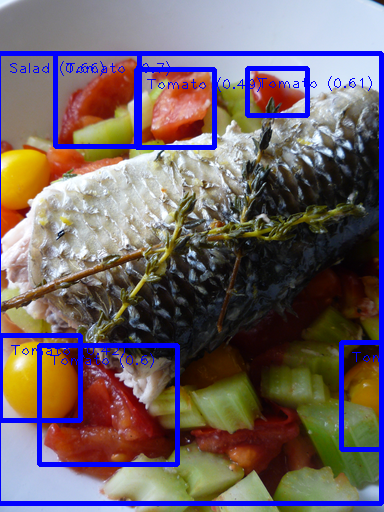

In [12]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(im)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path='model.tflite', options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)